In [3]:
from datasets import load_dataset

ds = load_dataset("HoangPhuc/data_spam_email")

combined_data.csv:   0%|          | 0.00/140M [00:00<?, ?B/s]

c:\Users\LENOVO\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\datasets--HoangPhuc--data_spam_email. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Generating train split:   0%|          | 0/83448 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 83448
    })
})

In [5]:
train_ds = ds["train"]


In [6]:
df = train_ds

In [11]:
import pandas as pd

df = pd.DataFrame({
    "text": train_ds["text"],
    "label": train_ds["label"]
})


In [12]:
df['label'].value_counts()

label
1    43910
0    39538
Name: count, dtype: int64

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [16]:
df = df.rename(columns={"text": "message"})


In [15]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
from sklearn.model_selection import train_test_split 

In [22]:
# First split: train vs temp
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=42, 
    stratify=df['label']
)

# Second split: validation vs test
valid_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=42, 
    stratify=temp_df['label']
)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))
print("Test size:", len(test_df))

Train size: 58413
Valid size: 12517
Test size: 12518


Total tokens (all occurrences): 15,091,630
Unique token types: 255,824

Top 30 tokens:
escapenumber : 797,598
         the : 502,019
          to : 333,515
         and : 248,295
          of : 235,039
           a : 220,137
          in : 171,370
  escapelong : 155,931
         you : 135,773
         for : 132,739
           i : 128,499
          is : 127,365
        that : 100,138
          on : 96,818
        this : 94,883
           s : 87,091
          it : 86,583
        with : 78,005
          be : 72,016
        your : 71,610
          as : 65,072
        from : 61,594
        have : 59,619
         are : 58,472
        http : 57,276
          at : 56,094
          we : 54,959
          or : 53,668
         not : 53,576
          by : 50,203


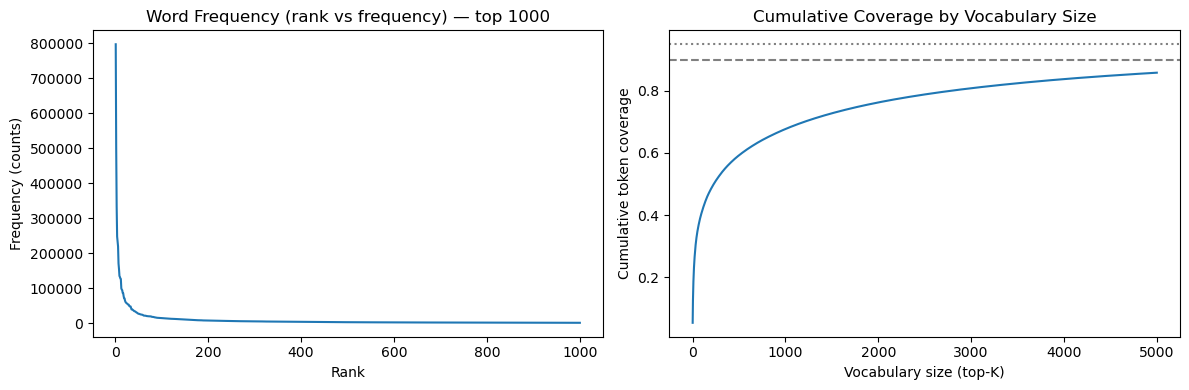

Top-8,568 tokens cover 90% of all token occurrences.
Top-22,824 tokens cover 95% of all token occurrences.
Top-65,798 tokens cover 98% of all token occurrences.

Recommended choices (research-oriented):
 - top-8,568  -> ~90% coverage (fast, smaller model)
 - top-22,824  -> ~95% coverage (balanced)
 - top-65,798  -> ~98% coverage (larger vocab)

Example rare tokens (last 50 types): ['iwzfglorshsw', 'alundil', 'hypersystem', 'perspectivity', 'sorcerer', 'aescapenumberissued', 'pokers', 'buttonholes', 'flaking', 'yojhur', 'tarshish', 'oppresseth', 'elishama', 'urinative', 'ghostwrites', 'coconspirator', 'dolium', 'skibby', 'scheduleswhat', 'zgzhjescapenumberu']


In [23]:
# Step 1: Vocabulary analysis (research-worthy)
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -- replace these if your train dataframe has a different name/column --
# train_df must exist and have a 'text' column
texts = train_df['message'].astype(str).tolist()

# 1) simple tokenization function (word-level, lowercased)
def simple_tokenize(text):
    # keeps alphanumerics as tokens (numbers preserved), splits on other chars
    return re.findall(r"\w+", text.lower())

# 2) build frequency counter
counter = Counter()
for t in texts:
    counter.update(simple_tokenize(t))

# 3) basic stats
total_unique = len(counter)
total_tokens = sum(counter.values())

print(f"Total tokens (all occurrences): {total_tokens:,}")
print(f"Unique token types: {total_unique:,}")

# 4) most common tokens (top 30)
print("\nTop 30 tokens:")
for word, freq in counter.most_common(30):
    print(f"{word:>12s} : {freq:,}")

# 5) prepare sorted frequency list and cumulative coverage
sorted_freqs = np.array([f for _, f in counter.most_common()])
ranks = np.arange(1, len(sorted_freqs) + 1)
cum_counts = np.cumsum(sorted_freqs)
cum_coverage = cum_counts / total_tokens

# 6) plot frequency curve (Zipf-like) and cumulative coverage
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ranks[:1000], sorted_freqs[:1000])
plt.title("Word Frequency (rank vs frequency) — top 1000")
plt.xlabel("Rank")
plt.ylabel("Frequency (counts)")

plt.subplot(1,2,2)
plt.plot(ranks[:5000], cum_coverage[:5000])
plt.axhline(0.90, color='gray', linestyle='--')  # 90% coverage line
plt.axhline(0.95, color='gray', linestyle=':')
plt.title("Cumulative Coverage by Vocabulary Size")
plt.xlabel("Vocabulary size (top-K)")
plt.ylabel("Cumulative token coverage")
plt.tight_layout()
plt.show()

# 7) find K for common coverage thresholds (90%, 95%, 98%)
def find_k_for_coverage(coverage=0.95):
    idx = np.searchsorted(cum_coverage, coverage)
    return idx + 1  # ranks are 1-indexed

for cov in (0.90, 0.95, 0.98):
    k = find_k_for_coverage(cov)
    print(f"Top-{k:,} tokens cover {int(cov*100)}% of all token occurrences.")

# 8) print recommended vocab sizes
k90 = find_k_for_coverage(0.90)
k95 = find_k_for_coverage(0.95)
k98 = find_k_for_coverage(0.98)
print("\nRecommended choices (research-oriented):")
print(f" - top-{k90:,}  -> ~90% coverage (fast, smaller model)")
print(f" - top-{k95:,}  -> ~95% coverage (balanced)")
print(f" - top-{k98:,}  -> ~98% coverage (larger vocab)")

# 9) optional: list some rare tokens (tail)
tail_sample = [w for w, f in counter.most_common()[-50:]]
print("\nExample rare tokens (last 50 types):", tail_sample[:20])


In [24]:
vocab_size = 10000

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Simple tokenizer for measuring length (not the TF tokenizer)
def simple_tokenize(text):
    return re.findall(r"\w+", text.lower())

# Compute lengths of each message
lengths = train_df['message'].astype(str).apply(lambda x: len(simple_tokenize(x))).values

print("Total messages:", len(lengths))
print("Max length:", lengths.max())
print("Average length:", lengths.mean())
print("Median length:", np.median(lengths))

# Percentile cutoffs
for p in [90, 95, 98, 99]:
    print(f"{p}th percentile:", np.percentile(lengths, p))

Total messages: 58413
Max length: 37136
Average length: 258.3608100936435
Median length: 143.0
90th percentile: 537.0
95th percentile: 743.0
98th percentile: 1199.760000000002
99th percentile: 1812.7599999999948


In [28]:
max_len = 200

In [27]:
train_df['message'] = train_df['message'].astype(str)
valid_df['message'] = valid_df['message'].astype(str)
test_df['message']  = test_df['message'].astype(str)

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

VOCAB_SIZE = vocab_size     # your value
MAX_LEN = max_len  # your value

# --- Prepare TextVectorization layer ---
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

# Fit ONLY on training text
vectorizer.adapt(train_df["message"].values)

print("Tokenizer vocabulary size:", len(vectorizer.get_vocabulary()))


Tokenizer vocabulary size: 10000


In [30]:
# Convert text → sequence integers
X_train = vectorizer(train_df["message"].values)
X_valid = vectorizer(valid_df["message"].values)
X_test  = vectorizer(test_df["message"].values)

# Convert labels
y_train = train_df["label"].values
y_valid = valid_df["label"].values
y_test  = test_df["label"].values

print("Example encoded text:", X_train[0][:20])

Example encoded text: tf.Tensor(
[  33    3   82  492 3994  419   11    5    7    1 8842 5203   12  174
  143  241   12   20 2632  135], shape=(20,), dtype=int64)


In [31]:
import numpy as np

VOCAB_SIZE = vocab_size   # <-- set yours here

def emb_dim_sqrt(v):
    return int(np.sqrt(v))

def emb_dim_log(v):
    return int(6 * np.log2(v))

def emb_dim_fourth_root(v):
    return int(3 * (v ** 0.25))

def emb_dim_industry(v):
    # choose the nearest of [50, 100, 200, 300]
    base = np.array([50, 100, 200, 300])
    idx = np.argmin(np.abs(base - np.sqrt(v)))
    return int(base[idx])

print("Embedding dimension suggestions:")
print("--------------------------------")
print("√V rule:", emb_dim_sqrt(VOCAB_SIZE))
print("6·log2(V) rule:", emb_dim_log(VOCAB_SIZE))
print("3·V^1/4 rule:", emb_dim_fourth_root(VOCAB_SIZE))
print("Industry (nearest):", emb_dim_industry(VOCAB_SIZE))


Embedding dimension suggestions:
--------------------------------
√V rule: 100
6·log2(V) rule: 79
3·V^1/4 rule: 30
Industry (nearest): 100


In [32]:
EMBED_DIM = 100

embedding_layer = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBED_DIM,
    mask_zero=True,
    name="embedding_layer"
)

In [33]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = {i: w for i, w in enumerate(class_weights)}
class_weights

{0: np.float64(1.0553006214770921), 1: np.float64(0.9502065914044963)}

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_hybrid_cnn_bilstm(MAX_LEN=200, VOCAB_SIZE=10000, EMBED_DIM=100):

    inp = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    # --- Embedding ---
    x = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        mask_zero=False
    )(inp)

    x = layers.SpatialDropout1D(0.2)(x)

    # === Branch 1: kernel size 3 ===
    b1 = layers.Conv1D(128, 3, padding="same")(x)
    b1 = layers.LayerNormalization()(b1)
    b1 = layers.Activation("relu")(b1)

    # === Branch 2: kernel size 5 ===
    b2 = layers.Conv1D(128, 5, padding="same")(x)
    b2 = layers.LayerNormalization()(b2)
    b2 = layers.Activation("relu")(b2)

    # === Branch 3: kernel size 7 ===
    b3 = layers.Conv1D(128, 7, padding="same")(x)
    b3 = layers.LayerNormalization()(b3)
    b3 = layers.Activation("relu")(b3)

    # === Concatenate features ===
    merged = layers.Concatenate()([b1, b2, b3])   # (N, 300, 384)

    # ⭐ NEW: Pooling to reduce sequence length for faster LSTM
    pooled = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(merged)
    # Now sequence length: 300 -> 150 → LSTM becomes ~2x faster

    # === Fusion convolution ===
    fused = layers.Conv1D(128, 1, padding="same")(pooled)
    fused = layers.LayerNormalization()(fused)
    fused = layers.Activation("relu")(fused)

    # === BiLSTM block ===
    lstm = layers.Bidirectional(
        layers.LSTM(128, return_sequences=False)
    )(fused)

    # === Dense head ===
    dense = layers.Dense(128, activation="relu")(lstm)
    dense = layers.Dropout(0.4)(dense)

    out = layers.Dense(1, activation="sigmoid")(dense)

    model = Model(inp, out)
    return model


In [69]:
model_dn = build_hybrid_cnn_bilstm(
    MAX_LEN=200,
    VOCAB_SIZE=10000,
    EMBED_DIM=100
)

model_dn.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_dn.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 200, 100)  │  1,000,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 200, 100)  │          0 │ embedding_7[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 200, 128)  │     38,528 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 200, 128)  │     64,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 200, 128)  │     89,728 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ conv1d_12[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ conv1d_13[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 200, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 200, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 200, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 200, 384)  │          0 │ activation_8[0][… │
│ (Concatenate)       │                   │            │ activation_9[0][… │
│                     │                   │            │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 100, 384)  │          0 │ concatenate_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 100, 128)  │     49,280 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ conv1d_15[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 100, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    263,168 │ activation_11[0]

 Total params: 1,538,881 (5.87 MB)

 Trainable params: 1,538,881 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_d = build_hybrid_cnn_bilstm(
    MAX_LEN=200,
    VOCAB_SIZE=10000,
    EMBED_DIM=100
)

model_d.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_d.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 100)  │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 200, 100)  │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 200, 128)  │     38,528 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 200, 128)  │     64,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 200, 128)  │     89,728 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ conv1d_4[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ conv1d_6[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 200, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 200, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 200, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 200, 384)  │          0 │ activation_4[0][… │
│ (Concatenate)       │                   │            │ activation_5[0][… │
│                     │                   │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 100, 384)  │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 100, 128)  │     49,280 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ conv1d_7[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 100, 128)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ activation_7[0][

 Total params: 1,538,881 (5.87 MB)

 Trainable params: 1,538,881 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_dn = model_dn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    class_weight=class_weights,
    epochs=3,
    batch_size=256)

Epoch 1/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 197s 844ms/step - accuracy: 0.9531 - auc: 0.9904 - loss: 0.1183 - val_accuracy: 0.9833 - val_auc: 0.9966 - val_loss: 0.0568
Epoch 2/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 201s 877ms/step - accuracy: 0.9880 - auc: 0.9980 - loss: 0.0408 - val_accuracy: 0.9799 - val_auc: 0.9970 - val_loss: 0.0651
Epoch 3/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 202s 881ms/step - accuracy: 0.9932 - auc: 0.9990 - loss: 0.0233 - val_accuracy: 0.9870 - val_auc: 0.9978 - val_loss: 0.0412


In [38]:
history_d = model_d.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    class_weight=class_weights,
    epochs=5,
    batch_size=256)

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 165s 692ms/step - accuracy: 0.9422 - auc: 0.9871 - loss: 0.1406 - val_accuracy: 0.9848 - val_auc: 0.9975 - val_loss: 0.0490
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 165s 720ms/step - accuracy: 0.9867 - auc: 0.9978 - loss: 0.0432 - val_accuracy: 0.9817 - val_auc: 0.9971 - val_loss: 0.0602
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 162s 707ms/step - accuracy: 0.9931 - auc: 0.9991 - loss: 0.0232 - val_accuracy: 0.9856 - val_auc: 0.9968 - val_loss: 0.0493
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 155s 676ms/step - accuracy: 0.9952 - auc: 0.9994 - loss: 0.0162 - val_accuracy: 0.9843 - val_auc: 0.9951 - val_loss: 0.0639
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 153s 669ms/step - accuracy: 0.9967 - auc: 0.9997 - loss: 0.0110 - val_accuracy: 0.9840 - val_auc: 0.9964 - val_loss: 0.0598


In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score ,classification_report

In [39]:
from sklearn.metrics import roc_curve
y_pred_prob = model_d.predict(X_test, batch_size=512)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
best_thresh = thresholds[(tpr - fpr).argmax()]
print(best_thresh)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step
0.05517804


In [42]:
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5865   66]
 [ 118 6469]]


In [43]:
# Metrics
acc_cb  = accuracy_score(y_test, y_pred)
prec_cb = precision_score(y_test, y_pred)
rec_cb  = recall_score(y_test, y_pred)
f1_cb   = f1_score(y_test, y_pred)

print("\n===== TEST RESULTS =====")
print(f"Accuracy  : {acc_cb:.4f}")
print(f"Precision : {prec_cb:.4f}")
print(f"Recall    : {rec_cb:.4f}")
print(f"F1-score  : {f1_cb:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))


===== TEST RESULTS =====
Accuracy  : 0.9853
Precision : 0.9899
Recall    : 0.9821
F1-score  : 0.9860

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9803    0.9889    0.9846      5931
           1     0.9899    0.9821    0.9860      6587

    accuracy                         0.9853     12518
   macro avg     0.9851    0.9855    0.9853     12518
weighted avg     0.9853    0.9853    0.9853     12518



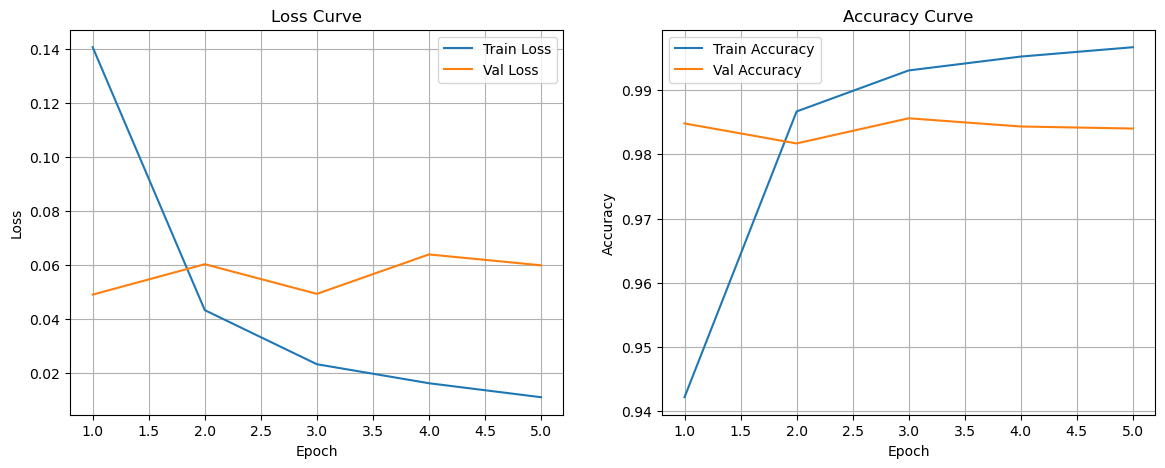

In [44]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(14,5))


    epochs = range(1, len(history.history['accuracy']) + 1)
    # ---- LOSS ----
    plt.subplot(1,2,1)
    plt.plot(epochs,history.history['loss'], label='Train Loss')
    plt.plot(epochs,history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # ---- ACC ----
    plt.subplot(1,2,2)
    plt.plot(epochs,history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs,history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()

# USE:
plot_training_curves(history_d)


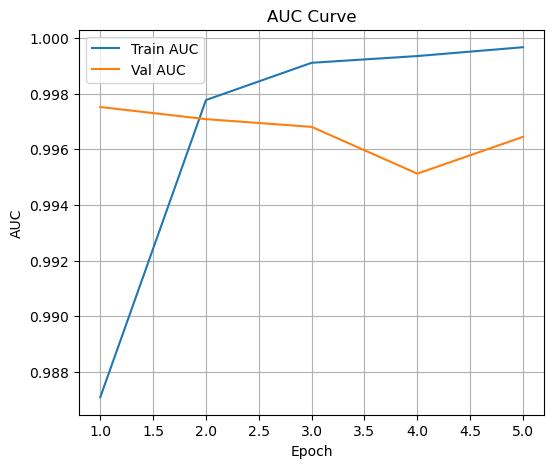

In [45]:
def plot_auc(history):
    if 'auc' not in history.history:
        print("AUC not found in metrics.")
        return
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(6,5))
    plt.plot(epochs,history.history['auc'], label='Train AUC')
    plt.plot(epochs,history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid()
    plt.show()

# USE:
plot_auc(history_d)


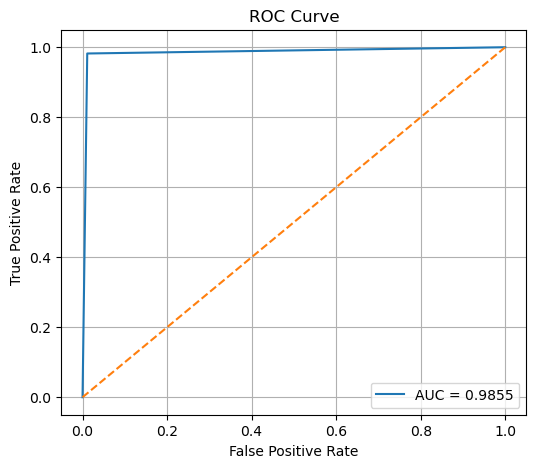

In [46]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    # y_prob = model.predict(X_test).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# USE:
plot_roc_curve(model_d, X_test, y_test)


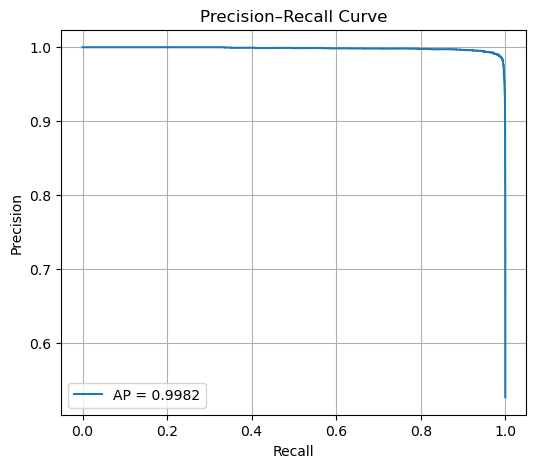

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(model, X_test, y_test):
    # y_prob = model.predict(X_test).ravel()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    ap = average_precision_score(y_test, y_pred_prob)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# USE:
plot_precision_recall(model_d, X_test, y_test)


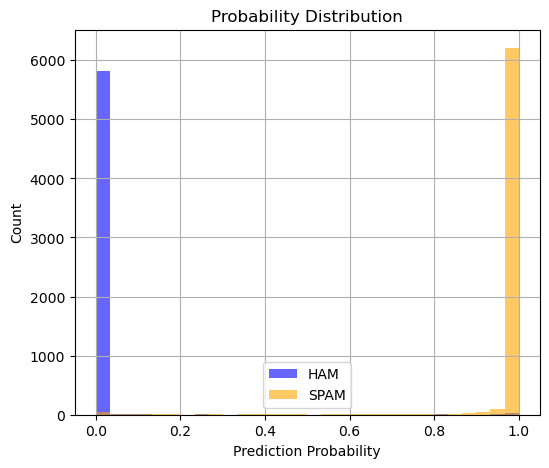

In [48]:
def plot_probability_histogram(model, X_test, y_test):
    # y_prob = model.predict(X_test).ravel()

    plt.figure(figsize=(6,5))
    plt.hist(y_pred_prob[y_test==0], bins=30, alpha=0.6, label="HAM", color="blue")
    plt.hist(y_pred_prob[y_test==1], bins=30, alpha=0.6, label="SPAM", color="orange")
    plt.xlabel("Prediction Probability")
    plt.ylabel("Count")
    plt.title("Probability Distribution")
    plt.legend()
    plt.grid()
    plt.show()

# USE:
plot_probability_histogram(model_d, X_test, y_test)

In [49]:
2

2

CNN 

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_cnn_model():
    inputs = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    x = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        mask_zero=True
    )(inputs)

    x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)


In [52]:
model_cnn = build_cnn_model()

model_cnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_cnn.summary()


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 200, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,965,633 (7.50 MB)

 Trainable params: 1,965,633 (7.50 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model_cnn.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=5,
    batch_size=256,
    class_weight=class_weights
)

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.9580 - auc: 0.9927 - loss: 0.1028 - val_accuracy: 0.9827 - val_auc: 0.9971 - val_loss: 0.0524
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.9916 - auc: 0.9989 - loss: 0.0279 - val_accuracy: 0.9872 - val_auc: 0.9976 - val_loss: 0.0441
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 32s 141ms/step - accuracy: 0.9956 - auc: 0.9996 - loss: 0.0140 - val_accuracy: 0.9867 - val_auc: 0.9963 - val_loss: 0.0525
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - accuracy: 0.9966 - auc: 0.9997 - loss: 0.0107 - val_accuracy: 0.9869 - val_auc: 0.9959 - val_loss: 0.0585
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 33s 146ms/step - accuracy: 0.9974 - auc: 0.9998 - loss: 0.0080 - val_accuracy: 0.9844 - val_auc: 0.9941 - val_loss: 0.0768


In [54]:
# Predict
y_pred_proba_cnn = model_cnn.predict(X_test)
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# Metrics
acc_c  = accuracy_score(y_test, y_pred_cnn)
prec_c = precision_score(y_test, y_pred_cnn)
rec_c  = recall_score(y_test, y_pred_cnn)
f1_c   = f1_score(y_test, y_pred_cnn)

print("\n===== TEST RESULTS =====")
print(f"Accuracy  : {acc_c:.4f}")
print(f"Precision : {prec_c:.4f}")
print(f"Recall    : {rec_c:.4f}")
print(f"F1-score  : {f1_c:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_cnn, digits=4))


 19/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

===== TEST RESULTS =====
Accuracy  : 0.9854
Precision : 0.9766
Recall    : 0.9961
F1-score  : 0.9862

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9955    0.9735    0.9844      5931
           1     0.9766    0.9961    0.9862      6587

    accuracy                         0.9854     12518
   macro avg     0.9861    0.9848    0.9853     12518
weighted avg     0.9856    0.9854    0.9854     12518



LSTM

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_lstm(MAX_LEN=200, VOCAB_SIZE=10000, EMBED_DIM=100):

    inputs = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    x = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        mask_zero=True
    )(inputs)

    x = layers.LSTM(128, return_sequences=False)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)


In [56]:
model_lstm = build_lstm(MAX_LEN, VOCAB_SIZE, EMBED_DIM)
# or model_bilstm = build_bilstm(MAX_LEN, VOCAB_SIZE, EMBED_DIM)

model_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ls = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=3,
    batch_size=256
)

Epoch 1/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 112s 477ms/step - accuracy: 0.9355 - auc: 0.9787 - loss: 0.1815 - val_accuracy: 0.9459 - val_auc: 0.9804 - val_loss: 0.2095
Epoch 2/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 122s 531ms/step - accuracy: 0.9415 - auc: 0.9830 - loss: 0.1633 - val_accuracy: 0.9672 - val_auc: 0.9916 - val_loss: 0.1058
Epoch 3/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 120s 523ms/step - accuracy: 0.9778 - auc: 0.9942 - loss: 0.0765 - val_accuracy: 0.9810 - val_auc: 0.9950 - val_loss: 0.0686


In [57]:
y_pred_prob_lstm = model_lstm.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

392/392 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step


In [58]:
# Metrics
acc1  = accuracy_score(y_test, y_pred_lstm)
prec1 = precision_score(y_test, y_pred_lstm)
rec1  = recall_score(y_test, y_pred_lstm)
f11   = f1_score(y_test, y_pred_lstm)

print("\n===== TEST RESULTS =====")
print(f"Accuracy  : {acc1:.4f}")
print(f"Precision : {prec1:.4f}")
print(f"Recall    : {rec1:.4f}")
print(f"F1-score  : {f11:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_lstm, digits=4))


===== TEST RESULTS =====
Accuracy  : 0.9831
Precision : 0.9833
Recall    : 0.9847
F1-score  : 0.9840

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9829    0.9815    0.9822      5931
           1     0.9833    0.9847    0.9840      6587

    accuracy                         0.9831     12518
   macro avg     0.9831    0.9831    0.9831     12518
weighted avg     0.9831    0.9831    0.9831     12518



In [59]:
BILSTM

NameError: name 'BILSTM' is not defined

In [60]:
def build_bilstm(MAX_LEN=200, VOCAB_SIZE=10000, EMBED_DIM=100):
    
    inputs = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    x = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        mask_zero=True
    )(inputs)

    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=False)
    )(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)

In [61]:

model_bilstm = build_bilstm(MAX_LEN, VOCAB_SIZE, EMBED_DIM)

model_bilstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_blstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=3,
    batch_size=256
)


Epoch 1/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.9563 - auc: 0.9920 - loss: 0.1105 - val_accuracy: 0.9859 - val_auc: 0.9978 - val_loss: 0.0450
Epoch 2/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.9895 - auc: 0.9982 - loss: 0.0366 - val_accuracy: 0.9849 - val_auc: 0.9981 - val_loss: 0.0448
Epoch 3/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9937 - auc: 0.9992 - loss: 0.0213 - val_accuracy: 0.9817 - val_auc: 0.9970 - val_loss: 0.0593


In [62]:
y_pred_prob_bilstm = model_bilstm.predict(X_test)
y_pred_bilstm = (y_pred_prob_bilstm > 0.5).astype(int)

392/392 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step


In [63]:

# Metrics

acc  = accuracy_score(y_test, y_pred_bilstm)
prec = precision_score(y_test, y_pred_bilstm)
rec  = recall_score(y_test, y_pred_bilstm)
f1   = f1_score(y_test, y_pred_bilstm)

print("\n===== TEST RESULTS =====")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_bilstm, digits=4))


===== TEST RESULTS =====
Accuracy  : 0.9823
Precision : 0.9889
Recall    : 0.9772
F1-score  : 0.9830

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9750    0.9879    0.9814      5931
           1     0.9889    0.9772    0.9830      6587

    accuracy                         0.9823     12518
   macro avg     0.9820    0.9825    0.9822     12518
weighted avg     0.9824    0.9823    0.9823     12518



In [ ]:
CNN+ LSTM

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_cnn_lstm(MAX_LEN=200, VOCAB_SIZE=10000, EMBED_DIM=100):
    inputs = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    x = layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        mask_zero=True
    )(inputs)

    # CNN feature extractor
    x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)

    # LSTM Layer
    x = layers.LSTM(128, return_sequences=False)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)


In [66]:
model_cnn_lstm = build_cnn_lstm(MAX_LEN, VOCAB_SIZE, EMBED_DIM)

model_cnn_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_cl = model_cnn_lstm.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=3,          # Keep fast (you can increase later)
    batch_size=256,
    class_weight = class_weights
)

Epoch 1/3


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_11' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


229/229 ━━━━━━━━━━━━━━━━━━━━ 66s 275ms/step - accuracy: 0.8496 - auc: 0.9224 - loss: 0.3536 - val_accuracy: 0.9700 - val_auc: 0.9935 - val_loss: 0.0940
Epoch 2/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - accuracy: 0.9773 - auc: 0.9936 - loss: 0.0755 - val_accuracy: 0.9811 - val_auc: 0.9969 - val_loss: 0.0565
Epoch 3/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 61s 266ms/step - accuracy: 0.9874 - auc: 0.9974 - loss: 0.0429 - val_accuracy: 0.9842 - val_auc: 0.9974 - val_loss: 0.0496


In [67]:
y_pred_prob = model_cnn_lstm.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


In [68]:
# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("\n===== TEST RESULTS =====")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))


===== TEST RESULTS =====
Accuracy  : 0.9846
Precision : 0.9803
Recall    : 0.9906
F1-score  : 0.9854

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9894    0.9779    0.9836      5931
           1     0.9803    0.9906    0.9854      6587

    accuracy                         0.9846     12518
   macro avg     0.9849    0.9843    0.9845     12518
weighted avg     0.9846    0.9846    0.9846     12518

